- name: dataAna.ipynb
- date: Nov. 21, 2024
- contact: JiaoWu2020@gmail.com
- environment: Python 3.11.9

## Environment preparation

In [2]:
# import packages
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from sklearn.linear_model import LinearRegression as lm
from scipy import stats
import math
import warnings

In [3]:
# get the working directories
codeDir = os.getcwd()
rootDir = os.path.abspath(os.path.join(codeDir, '..'))
oriDataDir = os.path.join(rootDir, '../seq_follow_pilot/data')
dataDir = os.path.join(rootDir, 'data')
figsDir = os.path.join(rootDir, 'figures')
statDir = os.path.join(rootDir, 'stats')

# set parameters
sns.set_context("notebook", font_scale=1.25)

# ignore warnings in pandas
pd.options.mode.chained_assignment = None # default='warn'

## Data loading and preparation

In [4]:
# get the list of data files
csv_files = glob.glob(os.path.join(oriDataDir, "seq_tasks_v2023_p*.csv"))
data = pd.DataFrame()

# read files and transform data
for i in range(len(csv_files)):
    parCSV = pd.read_csv(csv_files[i])

    # get useful columns
    df = parCSV.rename(columns = {'participant':'nPar', 'trials.thisRepN':'nB',\
            'trials.thisTrialN':'nT', 'duration':'curDur','cue':'curTask',\
            'rpr_duration':'rpr','follow_stimuli':'curflwDur','follow_production':'flw'})
    df = df[['nPar','nB','nT','curDur','curTask','rpr','curflwDur','flw']] # select columns

    # data transformation
    df = df.query('nB>0 & nPar.notnull()') # remove practice and rows with missing values
    df.nT = df.nT + 1 # convert nT to start from 1
    df['nT'] = df['nT'].astype(int) # convert nT to integer
    df['nB'] = df['nB'].astype(int) # convert nB to integer
    df['curflwDur'] = df['curflwDur'].round(1)
    df['nPar'] = df['nPar'].apply(lambda x: x[1:] if isinstance(x, str) else x)
    df['nPar'] = df['nPar'].astype(int)
    # exchange 'curDur' with 'curflwDur' in following condition, 
    # making 'curDur' to be the duration that observers made responses
    df.loc[df['curTask']=='following','curPreCueDur'] = df['curDur']
    df.loc[df['curTask']=='following','curDur'] = df['curflwDur']
    # add columns for previous task and duration (trial n-1)
    df['preTask'] = df['curTask'].shift(periods=1)
    df.loc[df['nT']==1, ['preTask']] = pd.NA
    df['preDur'] = df['curDur'].shift(periods=1)
    df.loc[df['nT']==1, ['preDur']] = pd.NA
    df = df[['nPar','nB','nT','curTask','curDur','rpr','flw','curPreCueDur','preTask','preDur']]
    # append the data
    data = pd.concat([data, df], ignore_index=True)

df.to_csv(os.path.join(dataDir, 'data_ori.csv'), index=False)

In [5]:
# data cleaning
data = pd.read_csv(dataDir + '/data_ori.csv')

# 1. get the distribution and Q-Q plot for reproduction (rpr) and follow (flw) responses
print('rpr range:[',data.query('rpr>0')['rpr'].min(),',',data.query('rpr>0')['rpr'].max(),']')
# df.query('rpr>0')['rpr'].hist(bins=20, color='grey', edgecolor='black')
# plt.show()
# stats.probplot(df.query('rpr>0')['rpr'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (rpr)")
# plt.show()

print('flw range:[',data.query('flw>0')['flw'].min(),',',data.query('flw>0')['flw'].max(),']')
# df.query('flw>0')['flw'].hist(bins=20, color='grey', edgecolor='black')
# plt.show()
# stats.probplot(df.query('flw>0')['flw'], dist="norm", plot=plt)
# plt.title("Q-Q Plot (flw)")
# plt.show() 

# 2. remove outliers
data['valid'] = 1 # no outliers in rpr and flw for current pilot data

# 3. save the cleaned data
data.to_csv(os.path.join(dataDir, 'dataAll.csv'), index=False)

rpr range:[ 0.4234185999998772 , 1.646555199999966 ]
flw range:[ 0.7173887999999806 , 1.5995059999995649 ]


In [6]:
# import data
data = pd.read_csv(dataDir + '/dataAll.csv')
dataValid = data.query('valid == 1')

# get parameters
nPar = len(dataValid.nPar.unique())
print('Number of participants: ' + str(nPar))

# get dataframe for current and previous trial analyses
dataRpr = dataValid.query('curTask == "reproduction"')
dataRpr['curBias'] = dataRpr['rpr'] - dataRpr['curDur']
dataRpr_pre = dataRpr.query('preTask.notnull()')

dataFlw = dataValid.query('curTask == "following"')
dataFlw['curBias'] = dataFlw['flw'] - dataFlw['curDur']
dataFlw_pre = dataFlw.query('preTask.notnull()')

# dataValid.head()

Number of participants: 1


In [7]:
# define function to calculate CTI and SDI by multiple linear regression
def calcCTISDI(data, nPar):
    slope_cti = np.zeros(nPar)
    slope_sdi = np.zeros(nPar)
    intercept = np.zeros(nPar)
    for i in range(1, nPar+1):
        tmp = data.query('nPar == @i')
        reg = lm().fit(tmp[['curDur', 'preDur']], tmp['curBias'])
        slope_cti[i-1] = reg.coef_[0]
        slope_sdi[i-1] = reg.coef_[1]
        intercept[i-1] = reg.intercept_ 
    return slope_cti, slope_sdi, intercept

# define function to do repeated measures ANOVA with Greenhouse-Geisser corrections
# provided long-format data
def rmANOVA_gg_Long(data, dv, within, subject):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if len(within) == 1:
            GGpass = pg.sphericity(data, dv=dv, subject=subject, within=within, method='greenhouse-geisser')[0]
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction= not GGpass)
            if not GGpass:
                aov['DF-GG-corr'] = aov['DF'] * aov['eps'][0]
                aov.drop(columns=['sphericity', 'W-spher', 'p-spher'], inplace=True)
                print('* The assumption of sphericity is violated for factor:', within)
            return aov
        elif len(within) == 2:
            GGpass = pd.Series([True,True,True])
            factorDict = {"0":within[0], "1":within[1], "2":within}
            for i in range(3):
                GGpass[i] = pg.sphericity(data, dv=dv, subject=subject, within=factorDict[str(i)], method='greenhouse-geisser')[0]
                if not GGpass[i]:
                    print('* The assumption of sphericity is violated for factor:', factorDict[str(i)])
            aov = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=True, effsize="np2", correction=True)
            eps = pd.Series([1,1,1])
            GGcrr = [not x for x in GGpass]
            eps[GGcrr] = aov['eps'][GGcrr]
            aov['DF1-GGcrr'] = aov['ddof1'] * eps
            aov['DF2-GGcrr'] = aov['ddof2'] * eps
            return aov


## 1. Reproduction task performance

### 1.1 Overall reproduction bias

In [8]:
# overall mean bias
genRprBias = dataRpr.groupby(['nPar']).curBias.mean().reset_index()
print(genRprBias)
print('mean rpr Bias:',genRprBias["curBias"].mean().round(3))
print('SE of rpr Bias:',genRprBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genRprBias['curBias'], 0).round(3))

   nPar   curBias
0     0 -0.155942
mean rpr Bias: -0.156
SE of rpr Bias: nan


mean of overall CV: 0.251
SE of overall CV: nan


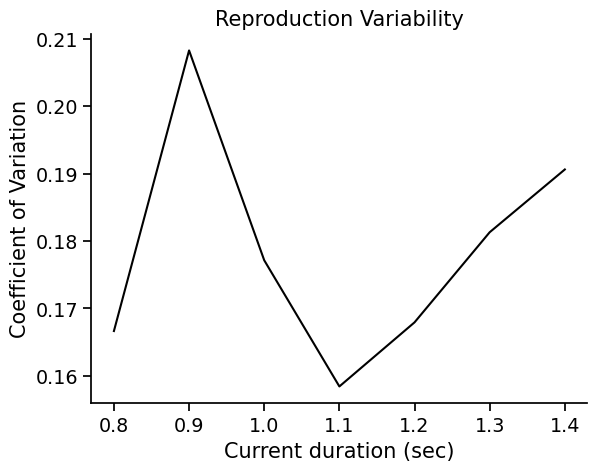

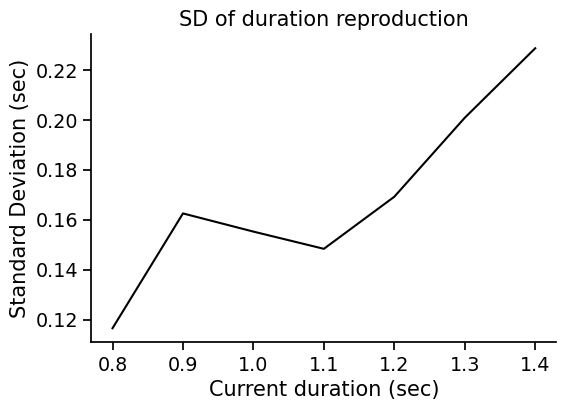

In [9]:
# overall mean reproduction CV
RprCV = dataRpr.groupby(['nPar']).agg({"rpr":["count","mean","std"]}).reset_index()
RprCV.columns = ['nPar', 'count', 'mean','std']
RprCV['cv'] = RprCV['std']/RprCV['mean']
# print(RprCV)
print('mean of overall CV:',RprCV["cv"].mean().round(3))
print('SE of overall CV:',RprCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(RprCV['cv'], 0).round(3))

# mean CV as a factor of duration
mCVPar = dataRpr.groupby(['nPar', 'curDur']).\
    agg({"rpr":["count","mean","std"]}).reset_index()
mCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mCVPar['cv'] = mCVPar['std']/mCVPar['mean']
mCVAll = mCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_cv_dur = rmANOVA_gg_Long(mCVPar, 'cv', ['curDur'], 'nPar')
# print(aov_cv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mCVAll, 
             color='black', capsize=4)
plt.xticks(mCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Reproduction Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mSDAll = mCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mSDAll,color='black',capsize=4)
plt.xticks(mSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration reproduction')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### 1.2 Central tendency effect

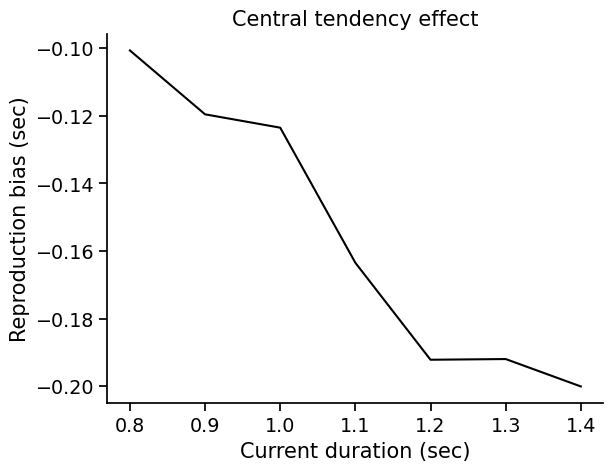

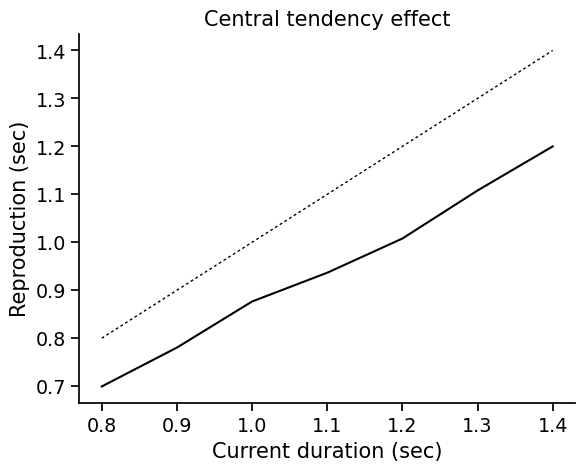

In [10]:
# Central tendency based on Reproduction Bias
mBiasDurPar = dataRpr.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mBiasDurAll = mBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean bias】')
# aov_bias_dur = rmANOVA_gg_Long(mBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_bias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mBiasDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig(figsDir + '/CT_RprErr.png', bbox_inches='tight')

# Central tendency based on Reproduction
mRprDurPar = dataRpr.groupby(['nPar', 'curDur']).rpr.mean().reset_index()
mRprDurAll = mRprDurPar.groupby('curDur').\
    agg({"rpr":["count","mean","sem"]}).reset_index()
mRprDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
#print(mRprDurAll)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mRprDurAll, 
             color='black', capsize=4)
plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
plt.xticks(mRprDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Reproduction (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig(figsDir + '/CT_Rpr.png', bbox_inches='tight')

### 1.3 Sequential effect or Serial dependence

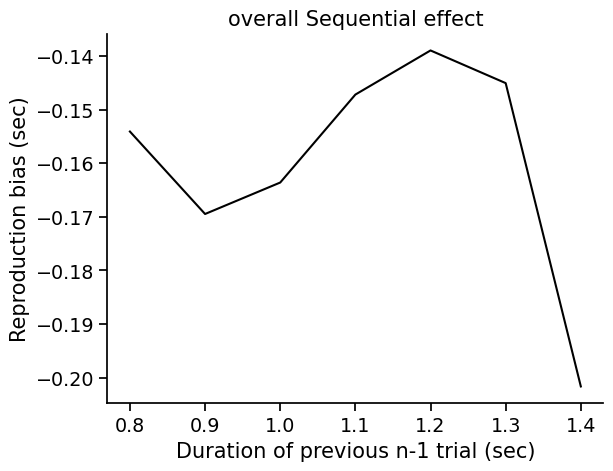

In [11]:
# overall Sequential effect (based on Reproduction Bias)
mBiasPreDurPar = dataRpr_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mBiasPreDurAll = mBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean Bias on preDuration】')
# aov_bias_preDur = rmANOVA_gg_Long(mBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_bias_preDur)

# plot sequential effect
fig, ax = plt.subplots()
plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mBiasPreDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mBiasPreDurAll.preDur)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('overall Sequential effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_RprErr.png', bbox_inches='tight')

         preTask  preDur  count     mBias  seBias
0      following     0.8      1 -0.140712     NaN
1      following     0.9      1 -0.189140     NaN
2      following     1.0      1 -0.201932     NaN
3      following     1.1      1 -0.163788     NaN
4      following     1.2      1 -0.134638     NaN
5      following     1.3      1 -0.155758     NaN
6      following     1.4      1 -0.214954     NaN
7   reproduction     0.8      1 -0.168713     NaN
8   reproduction     0.9      1 -0.151601     NaN
9   reproduction     1.0      1 -0.136020     NaN
10  reproduction     1.1      1 -0.131868     NaN
11  reproduction     1.2      1 -0.142432     NaN
12  reproduction     1.3      1 -0.135368     NaN
13  reproduction     1.4      1 -0.181245     NaN


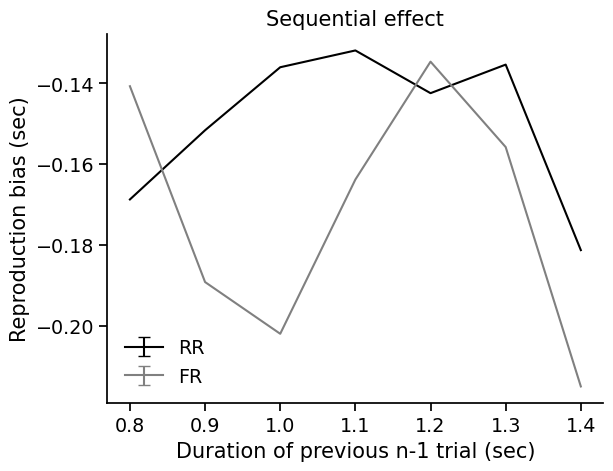

In [12]:
# Sequential effect between RR and FR
seqTaskPar = dataRpr_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqTaskAll = seqTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
print(seqTaskAll)

# plot sequential effect between RR and JR
data_RR = seqTaskAll.query('preTask=="reproduction"')
data_FR = seqTaskAll.query('preTask=="following"')
fig, ax = plt.subplots()
ax.errorbar(data_RR.preDur, data_RR.mBias, data_RR.seBias, 
             color='black', capsize=4, label='RR')
ax.errorbar(data_FR.preDur, data_FR.mBias, data_FR.seBias, 
             color='grey', capsize=4, label='FR')
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_RR.preDur)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Reproduction bias (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_RRvsFR.png', bbox_inches='tight')

In [13]:
# calculate SDI and plot
dataRR = dataRpr_pre.query('preTask=="reproduction"')
dataFR = dataRpr_pre.query('preTask=="following"')
# slope_RR_cti, slope_RR_sdi, intercept_RR = calcCTISDI(dataRR, nPar)
# print("mean SDI slope in RR: ", slope_RR_sdi.mean().round(3))
# print("std SDI slope in RR: ", round(slope_RR_sdi.std()/np.sqrt(nPar),3))
# print(pg.ttest(slope_RR_sdi, 0).round(5))

# slope_FR_cti, slope_FR_sdi, intercept_FR = calcCTISDI(dataFR, nPar)
# print("mean SDI slope in FR: ", slope_FR_sdi.mean().round(3))
# print("std SDI slope in FR: ", round(slope_FR_sdi.std()/np.sqrt(nPar),3))
# print(pg.ttest(slope_FR_sdi, 0).round(5))

# print("【Comparison of SDI in RR vs FR】")
# print(pg.ttest(slope_RR_sdi, slope_FR_sdi, paired=True).round(5))

## for pilot only
reg = lm().fit(dataRR[['curDur', 'preDur']], dataRR['curBias'])
slope_RR_cti = reg.coef_[0]
slope_RR_sdi = reg.coef_[1]

reg2 = lm().fit(dataFR[['curDur', 'preDur']], dataFR['curBias'])
slope_FR_cti = reg2.coef_[0]
slope_FR_sdi = reg2.coef_[1]

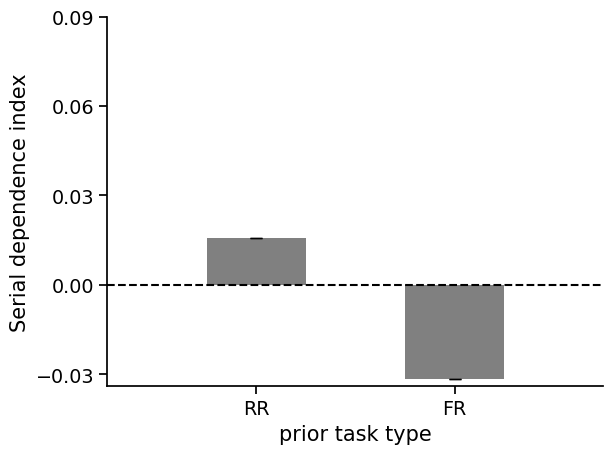

In [14]:
# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_RR_sdi), np.mean(slope_FR_sdi)],
             yerr=[np.std(slope_RR_sdi)/np.sqrt(nPar), np.std(slope_FR_sdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['RR', 'FR'])
plt.yticks(np.arange(-0.03, 0.1, 0.03))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_RRvsFR_SDI.png', bbox_inches='tight')

## 2. Follow task performance

### 2.1 overall follow bias

In [15]:
# overall mean bias
genFlwBias = dataFlw.groupby(['nPar']).curBias.mean().reset_index()
print(genFlwBias)
print('mean follow Bias:',genFlwBias["curBias"].mean().round(3))
print('SE of follow Bias:',genFlwBias["curBias"].sem().round(3))
# print('【The overall bias compared to zero】')
# print(pg.ttest(genFlwBias['curBias'], 0).round(3))

   nPar   curBias
0     0  0.048715
mean follow Bias: 0.049
SE of follow Bias: nan


mean of overall follow CV: 0.158
SE of overall follow CV: nan


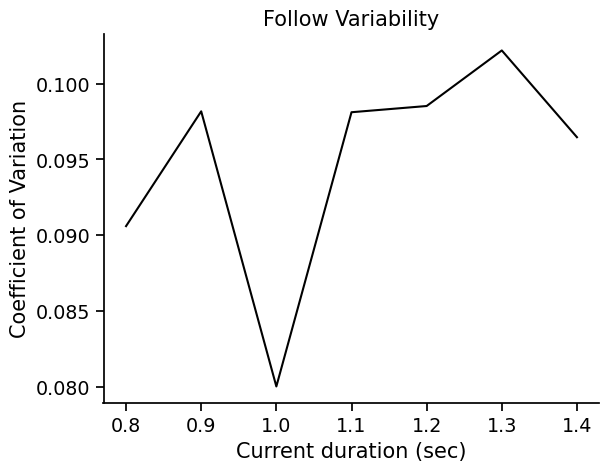

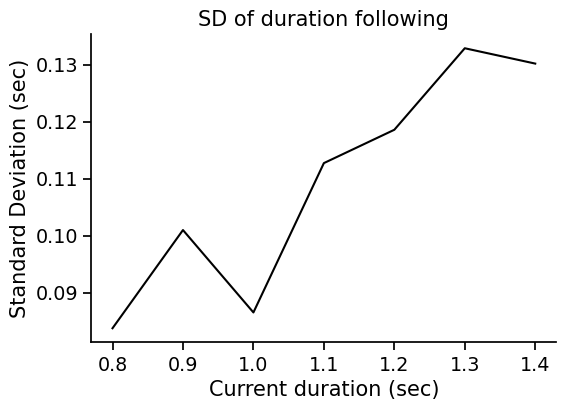

In [16]:
# overall mean follow CV
FlwCV = dataFlw.groupby(['nPar']).agg({"flw":["count","mean","std"]}).reset_index()
FlwCV.columns = ['nPar', 'count', 'mean','std']
FlwCV['cv'] = FlwCV['std']/FlwCV['mean']
# print(FlwCV)
print('mean of overall follow CV:',FlwCV["cv"].mean().round(3))
print('SE of overall follow CV:',FlwCV["cv"].sem().round(3))
# print('【The overall CV compared to zero】')
# print(pg.ttest(FlwCV['cv'], 0).round(3))

# mean CV as a factor of duration
mFlwCVPar = dataFlw.groupby(['nPar', 'curDur']).\
    agg({"flw":["count","mean","std"]}).reset_index()
mFlwCVPar.columns = ['nPar', 'curDur','count', 'mean','std']
mFlwCVPar['cv'] = mFlwCVPar['std']/mFlwCVPar['mean']
mFlwCVAll = mFlwCVPar.groupby(['curDur']).agg({"cv":["count","mean","sem"]}).reset_index()
mFlwCVAll.columns = ['curDur', 'count', 'mCV','seCV']
# print(mFlwCVAll)
# print('【rmANOVA: Duration main effect on mean CV】')
# aov_flwcv_dur = rmANOVA_gg_Long(mFlwCVAll, 'cv', ['curDur'], 'nPar')
# print(aov_flwcv_dur)

# plot CV
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mCV', yerr='seCV', data=mFlwCVAll, 
             color='black', capsize=4)
plt.xticks(mFlwCVAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Coefficient of Variation')
plt.title('Follow Variability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plot SD
mFlwSDAll = mFlwCVPar.groupby(['curDur']).agg({"std":["count","mean","sem"]}).reset_index()
mFlwSDAll.columns = ['curDur', 'count', 'mSD','seSD']
#print(mFlwSDAll)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.errorbar(x='curDur',y='mSD',yerr='seSD',data=mFlwSDAll,color='black',capsize=4)
plt.xticks(mFlwSDAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Standard Deviation (sec)')
plt.title('SD of duration following')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### 2.2 Central tendency effect

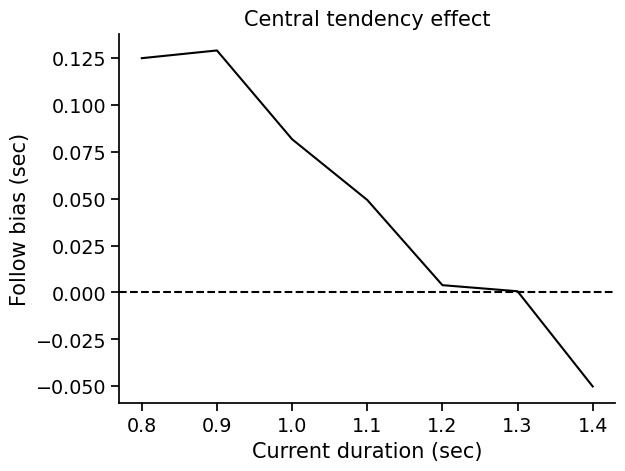

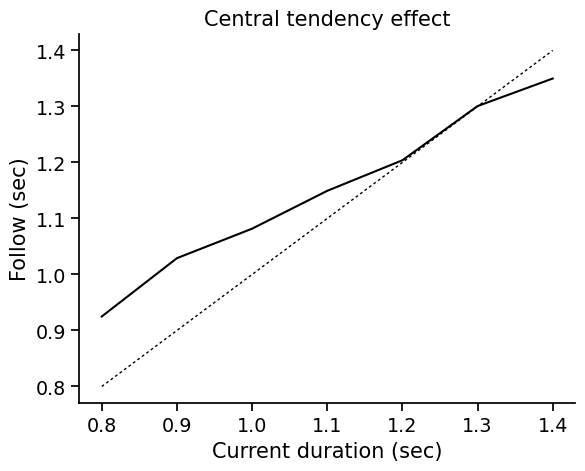

In [ ]:
# Central tendency based on Reproduction Bias
mFlwBiasDurPar = dataFlw.groupby(['nPar', 'curDur']).curBias.mean().reset_index()
mFlwBiasDurAll = mFlwBiasDurPar.groupby('curDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasDurAll.columns = ['curDur', 'count', 'mBias','seBias']
#print(mFlwBiasDurAll)

# rmANOVA: mean bias as a factor of duration
# print('【rmANOVA: Duration main effect on mean follow bias】')
# aov_flwbias_dur = rmANOVA_gg_Long(mFlwBiasDurPar, 'curBias', ['curDur'], 'nPar')
# print(aov_flwbias_dur)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mBias', yerr='seBias', data=mFlwBiasDurAll, 
             color='black', capsize=4)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwBiasDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.savefig(figsDir + '/CT_FlwErr.png', bbox_inches='tight')

# Central tendency based on Reproduction
mFlwDurPar = dataFlw.groupby(['nPar', 'curDur']).flw.mean().reset_index()
mFlwDurAll = mFlwDurPar.groupby('curDur').\
    agg({"flw":["count","mean","sem"]}).reset_index()
mFlwDurAll.columns = ['curDur', 'count', 'mRpr','seRpr']
#print(mFlwDurAll)

# plot central tendency
fig, ax = plt.subplots()
plt.errorbar(x='curDur', y='mRpr', yerr='seRpr', data=mFlwDurAll, 
             color='black', capsize=4)
plt.plot([0.8, 1.4], [0.8, 1.4], 'k-', lw=1, dashes=[2, 2])
plt.xticks(mFlwDurAll.curDur)
plt.xlabel('Current duration (sec)')
plt.ylabel('Follow (sec)')
plt.title('Central tendency effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/CT_Flw.png', bbox_inches='tight')

### 2.3 Sequential effect or Serial dependence

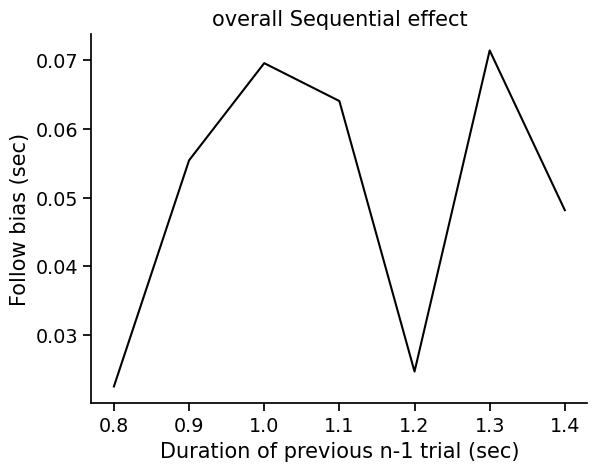

In [95]:
# overall Sequential effect (based on Reproduction Bias)
mFlwBiasPreDurPar = dataFlw_pre.groupby(['nPar','preDur']).curBias.mean().reset_index()
mFlwBiasPreDurAll = mFlwBiasPreDurPar.groupby('preDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasPreDurAll.columns = ['preDur', 'count', 'mBias','seBias']
# print(mFlwBiasPreDurAll)

# rmANOVA: mean bias as a factor of pre-duration
# print('【rmANOVA of mean follow Bias on preDuration】')
# aov_flwbias_preDur = rmANOVA_gg_Long(mFlwBiasPreDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_flwbias_preDur)

# plot sequential effect
fig, ax = plt.subplots()
plt.errorbar(x='preDur', y='mBias', yerr='seBias', data=mFlwBiasPreDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwBiasPreDurAll.preDur)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('overall Sequential effect')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FlwErr.png', bbox_inches='tight')

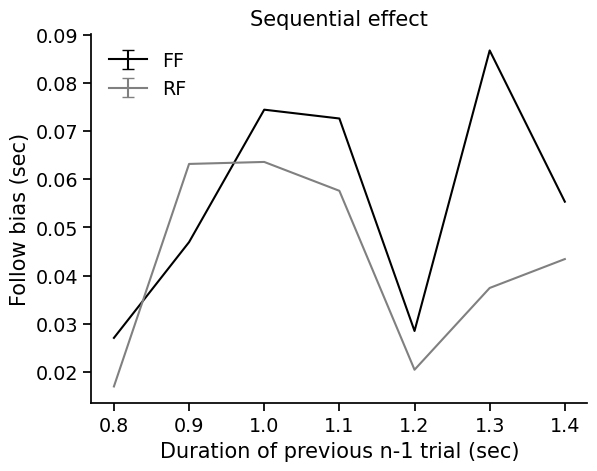

In [ ]:
# Sequential effect between FF and RF
seqFlwTaskPar = dataFlw_pre.groupby(['nPar', 'preTask', 'preDur']).curBias.mean().reset_index()
seqFlwTaskAll = seqFlwTaskPar.groupby(['preTask', 'preDur']).\
    agg({"curBias":["count","mean","sem"]}).reset_index()
seqFlwTaskAll.columns = ['preTask', 'preDur', 'count', 'mBias','seBias']
# print(seqFlwTaskAll)

# plot sequential effect between FF and RF
data_FF = seqFlwTaskAll.query('preTask=="following"')
data_RF = seqFlwTaskAll.query('preTask=="reproduction"')
fig, ax = plt.subplots()
ax.errorbar(data_FF.preDur, data_FF.mBias, data_FF.seBias, 
             color='black', capsize=4, label='FF')
ax.errorbar(data_RF.preDur, data_RF.mBias, data_RF.seBias, 
             color='grey', capsize=4, label='RF')
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(data_FF.preDur)
plt.xlabel('Duration of previous n-1 trial (sec)')
plt.ylabel('Follow bias (sec)')
plt.title('Sequential effect')
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FFvsRF.png', bbox_inches='tight')

In [97]:
# calculate SDI and plot
dataFF = dataFlw_pre.query('preTask=="following"')
dataRF = dataFlw_pre.query('preTask=="reproduction"')

# slope_FF_cti, slope_FF_sdi, intercept_FF = calcCTISDI(dataFF, nPar)
# print("mean SDI slope in FF: ", slope_FF_sdi.mean().round(3))
# print("std SDI slope in FF: ", round(slope_FF_sdi.std()/np.sqrt(nPar),3))
# print(pg.ttest(slope_FF_sdi, 0).round(5))

# slope_RF_cti, slope_RF_sdi, intercept_RF = calcCTISDI(dataRF, nPar)
# print("mean SDI slope in RF: ", slope_RF_sdi.mean().round(3))
# print("std SDI slope in RF: ", round(slope_RF_sdi.std()/np.sqrt(nPar),3))
# print(pg.ttest(slope_RF_sdi, 0).round(5))

# print("【Comparison of SDI in FF vs RF】")
# print(pg.ttest(slope_FF_sdi, slope_RF_sdi, paired=True).round(5))

## for pilot only
reg = lm().fit(dataFF[['curDur', 'preDur']], dataFF['curBias'])
slope_FF_cti = reg.coef_[0]
slope_FF_sdi = reg.coef_[1]

reg2 = lm().fit(dataRF[['curDur', 'preDur']], dataRF['curBias'])
slope_RF_cti = reg2.coef_[0]
slope_RF_sdi = reg2.coef_[1]

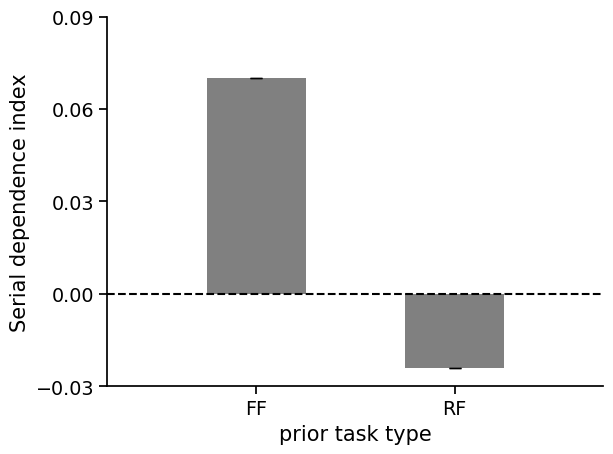

In [ ]:
# plot serial dependence index with errorbar
fig, ax = plt.subplots()
plt.bar(np.arange(1,3), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi)], color='grey', width=0.5)
plt.errorbar(np.arange(1,3), [np.mean(slope_FF_sdi), np.mean(slope_RF_sdi)],
             yerr=[np.std(slope_FF_sdi)/np.sqrt(nPar), np.std(slope_RF_sdi)/np.sqrt(nPar)],
             color='black', capsize=4, linestyle='')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(0.25,2.75)
plt.xticks(np.arange(1,3), ['FF', 'RF'])
plt.yticks(np.arange(-0.03, 0.1, 0.03))
plt.xlabel('prior task type')
plt.ylabel('Serial dependence index')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FFvsRF_SDI.png', bbox_inches='tight')

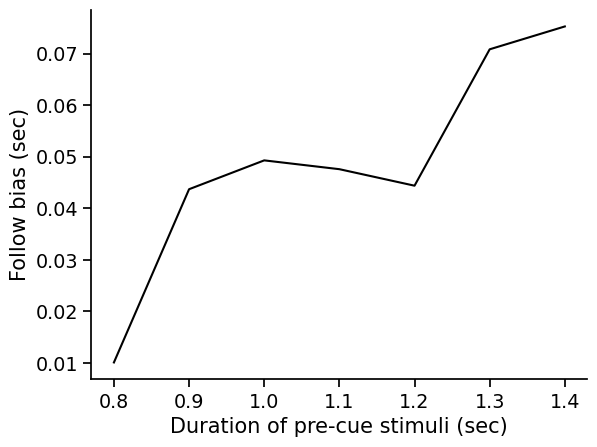

In [ ]:
# sequential effect from the pre-cue duration
mFlwBiasPreCueDurPar = dataFlw.groupby(['nPar','curPreCueDur']).curBias.mean().reset_index()
mFlwBiasPreCueDurAll = mFlwBiasPreCueDurPar.groupby('curPreCueDur').\
    agg({"curBias":["count","mean","sem"]}).reset_index()
mFlwBiasPreCueDurAll.columns = ['curPreCueDur', 'count', 'mBias','seBias']
# print(mFlwBiasPreCueDurAll)

# rmANOVA: mean bias as a factor of pre-cue duration
# print('【rmANOVA of mean follow Bias on pre-cue Duration】')
# aov_flwbias_preCueDur = rmANOVA_gg_Long(mFlwBiasPreCueDurPar, 'curBias', ['preDur'], 'nPar')
# print(aov_flwbias_preCueDur)

# plot sequential effect
fig, ax = plt.subplots()
plt.errorbar(x='curPreCueDur', y='mBias', yerr='seBias', data=mFlwBiasPreCueDurAll, 
             color='black', capsize=4)
# plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(mFlwBiasPreCueDurAll.curPreCueDur)
plt.xlabel('Duration of pre-cue stimuli (sec)')
plt.ylabel('Follow bias (sec)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig(figsDir + '/SeqEff_FlwErr_preCueDur.png', bbox_inches='tight')